In [43]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#자연발생 클러스터링(민원 단계 컬럼 생성)
from jenkspy import JenksNaturalBreaks

#parks_df = pd.read_csv("src/RF_parksdf_week.csv")
#parks_df = pd.read_csv("src/RF_parksdf_sat.csv")
parks_df = pd.read_csv("src/RF_parksdf_holi.csv")
parks_df.columns

i = 3

breaks = JenksNaturalBreaks(n_classes=i)
breaks.fit(parks_df["complaints_r300"])
print(breaks.breaks_)  # 구간 경계

parks_df["complaint_level"] = pd.cut(
    parks_df["complaints_r300"], bins=breaks.breaks_, labels=range(i), include_lowest=True
)
parks_df["complaint_level"].value_counts()

[0, 690, 2209, 7210]


complaint_level
0    1153
1     210
2      42
Name: count, dtype: int64

In [45]:
#범주형 변수의 label을 [0,1]로 변환
from sklearn.preprocessing import LabelEncoder

le_dict = {}

for col in ["parking_type", "operation_type", "Weekday_paid", "Saturday_paid", "Holiday_paid"]:
    if col in parks_df.columns:  # ✅ 존재하는 경우에만 처리
        le = LabelEncoder()
        parks_df[col] = le.fit_transform(parks_df[col])
        le_dict[col] = le

# 예시: parking_type의 범주와 정수 매핑 확인
for col in le_dict:
    print(f"{col}: {list(le_dict[col].classes_)}")

# [0, 1, 2, ...] 순서로 classes_에 저장됨
#['NS', 'NW'] -> [0,1]
#[1, 3] -> [0,1]
#['N', 'Y'] -> [0,1]
#['N', 'Y'] -> [0,1]
#['N', 'Y'] -> [0,1]

parking_type: ['NS', 'NW']
operation_type: [1, 3]
Holiday_paid: ['N', 'Y']


In [46]:
X = parks_df.drop(["complaints_r300", "complaint_level", "address"], axis=1)
y = parks_df["complaint_level"]

X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
rf_full = RandomForestClassifier(random_state=0)
rf_full.fit(X_train_full, y_train)

# 중요도 기반 상위 10개 변수 선택
importances = pd.Series(rf_full.feature_importances_, index=X.columns)
top10_features = importances.sort_values(ascending=False).head(9).index.tolist()

X_new = X[top10_features]

print("X_new 변수 목록:", top10_features)

X_new 변수 목록: ['total_parking_spaces', 'bus_r300', 'cctv_r300', 'fee1H', 'base_parking_fee', 'additional_unit_fee', 'Holiday_start', 'Holiday_operatingHours', 'Holiday_end']


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 1/9, random_state = 42)

X_new.columns

Index(['total_parking_spaces', 'bus_r300', 'cctv_r300', 'fee1H',
       'base_parking_fee', 'additional_unit_fee', 'Holiday_start',
       'Holiday_operatingHours', 'Holiday_end'],
      dtype='object')

In [48]:
# 랜덤포레스트 
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.8865


In [49]:
# gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=0)
gb.fit(X_train, y_train)
pred = gb.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('gradient boosting 정확도: {:.4f}'.format(accuracy))

gradient boosting 정확도: 0.9007


In [50]:
importances = rf.feature_importances_
feature_names = X_new.columns  # DataFrame에서 feature 이름 추출

# 중요도 표 만들기
importance_table = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

importance_table


,feature,importance
0,total_parking_spaces,0.238154
1,bus_r300,0.206019
2,cctv_r300,0.160016
3,fee1H,0.107870
4,base_parking_fee,0.089941
5,additional_unit_fee,0.071154
6,Holiday_start,0.069525
7,Holiday_operatingHours,0.032437
8,Holiday_end,0.024883


In [ ]:
from sklearn.metrics import mean_squared_error
import pandas as pd
pd.set_option('display.max_rows', None)

# 여기 요일타입에 따라 바꿔야 됩니다!!
dong_parks_df = pd.read_csv("dongParks_Holiday.csv")

dong_parks_df

# dong_parks_df의 feature 컬럼만 추출 (dong 이름 등 식별자 제외)
# 모델이 학습할 때 사용한 feature 리스트
model_features = list(feature_names)  # 또는 직접 리스트 입력

# dong_parks_df에서 해당 컬럼만 추출
X_dong = dong_parks_df[model_features]
# 동별 민원 수준 예측
dong_parks_df['predicted_complaints'] = rf.predict(X_dong)

# 그룹별 동 이름 추출
high_dong = dong_parks_df[dong_parks_df['predicted_complaints'] == 2]['dong']
mid_dong = dong_parks_df[dong_parks_df['predicted_complaints'] == 1]['dong']
low_dong = dong_parks_df[dong_parks_df['predicted_complaints'] == 0]['dong']

# 각 그룹을 DataFrame으로 변환 (인덱스 리셋)
high_df = pd.DataFrame({'High 민원': high_dong.reset_index(drop=True)})
mid_df = pd.DataFrame({'Mid 민원': mid_dong.reset_index(drop=True)})
low_df = pd.DataFrame({'Low 민원': low_dong.reset_index(drop=True)})

# 길이가 다른 경우도 맞춰서 하나의 표로 합치기
dong_table = pd.concat([high_df, mid_df, low_df], axis=1)

from IPython.display import display
display(dong_table)



,High 민원,Mid 민원,Low 민원
0,성산1동,구산동,가락본동
1,우장산동,구의2동,가리봉동
2,화곡3동,도림동,가산동
3,황학동,방배본동,가양1동
4,NaN,서빙고동,가양2동
5,NaN,성산2동,가양3동
6,NaN,신길3동,갈현1동
7,NaN,신원동,강일동
8,NaN,신월5동,개봉1동
9,NaN,약수동,개포1동


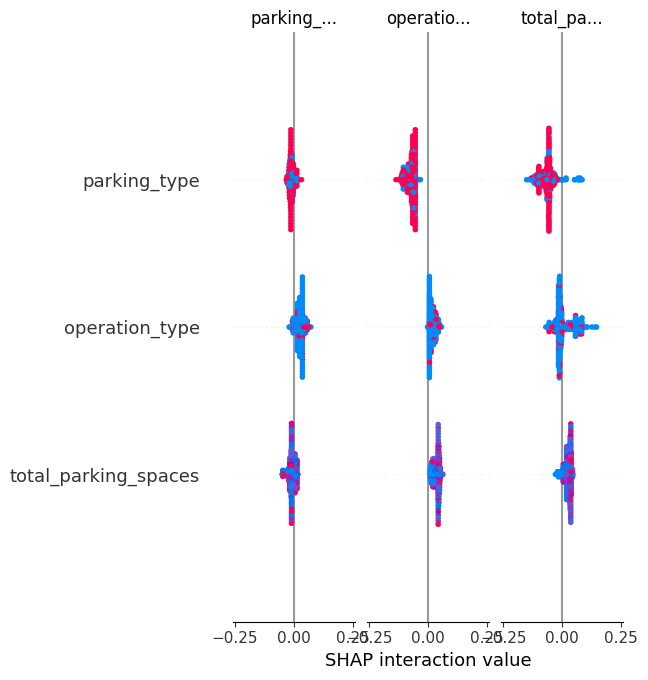

In [42]:
import shap

# 1. dong_parks_df에서 feature 컬럼만 추출 (동 이름 등 식별자 제외)
feature_cols = [col for col in dong_parks_df.columns 
                if col not in ['dong', 'predicted_complaints', 'actual_complaints', '동이름', '기타식별자']]

X_dong = dong_parks_df[feature_cols]

# 2. SHAP explainer 생성
explainer = shap.TreeExplainer(rf)

# 3. SHAP 값 계산
shap_values = explainer.shap_values(X_dong)

# 4. summary_plot으로 영향력 시각화
shap.summary_plot(shap_values, X_dong)

In [15]:
dong_parks_df.columns

Index(['dong', 'parking_type', 'operation_type', 'total_parking_spaces',
       'Weekday_paid', 'Weekday_start', 'Weekday_end', 'base_parking_fee',
       'base_parking_time', 'additional_unit_fee', 'additional_unit_time',
       'fee1H', 'Weekday_operatingHours', 'cctv_r300', 'bus_r300',
       'complaints_r300_Weekday', 'complaint_level', 'predicted_complaints'],
      dtype='object')

In [25]:
import shap
import matplotlib.pyplot as plt

# 1. feature 컬럼만 추출 (dong 등 식별자 제외)
feature_cols = [col for col in dong_parks_df.columns if col not in [
    'dong', 'complaint_level','predicted_complaints' 
]]

high_dong_df = dong_parks_df[dong_parks_df['predicted_complaints']==2]
mid_dong_df = dong_parks_df[dong_parks_df['predicted_complaints']==1]
#high_dong_df
X_dong = high_dong_df[feature_cols].combine(mid_dong_df[feature_cols])

# 2. SHAP explainer 생성
explainer = shap.TreeExplainer(rf)

# 3. SHAP 값 계산
shap_values = explainer.shap_values(X_dong)

# 4. 개별 행정동(예: 첫 번째 동) force plot
#idx = 0  # 시각화할 동의 인덱스
#shap.force_plot(
#    explainer.expected_value, 
#    shap_values[idx, :], 
#    X_dong.iloc[idx, :], 
#    matplotlib=True
#)
#plt.show()

TypeError: DataFrame.combine() missing 1 required positional argument: 'func'

dong_parks_df.columns
>> Index(['dong', 'parking_type', 'operation_type', 'total_parking_spaces',
       'Saturday_paid', 'Saturday_start', 'Saturday_end', 'base_parking_fee',
       'base_parking_time', 'additional_unit_fee', 'additional_unit_time',
       'fee1H', 'Saturday_operatingHours', 'cctv_r300', 'bus_r300',
       'complaints_r300_Saturday', 'complaint_level'],
      dtype='object')

model_features
>>['total_parking_spaces',
 'bus_r300',
 'cctv_r300',
 'fee1H',
 'base_parking_fee',
 'additional_unit_fee',
 'Holiday_start',
 'Holiday_end',
 'Holiday_operatingHours']

In [11]:
# Accuracy 분석

from sklearn.metrics import classification_report, accuracy_score

print("Complaint Level (Kmeans) Classification Accuracy:", round(accuracy_score(y_test, pred), 3))
print(classification_report(y_test, pred, target_names=['Low', 'Mid', 'High']))

Complaint Level (Kmeans) Classification Accuracy: 0.837
              precision    recall  f1-score   support

         Low       0.84      0.96      0.90       106
         Mid       0.76      0.42      0.54        31
        High       1.00      0.75      0.86         4

    accuracy                           0.84       141
   macro avg       0.87      0.71      0.77       141
weighted avg       0.83      0.84      0.82       141



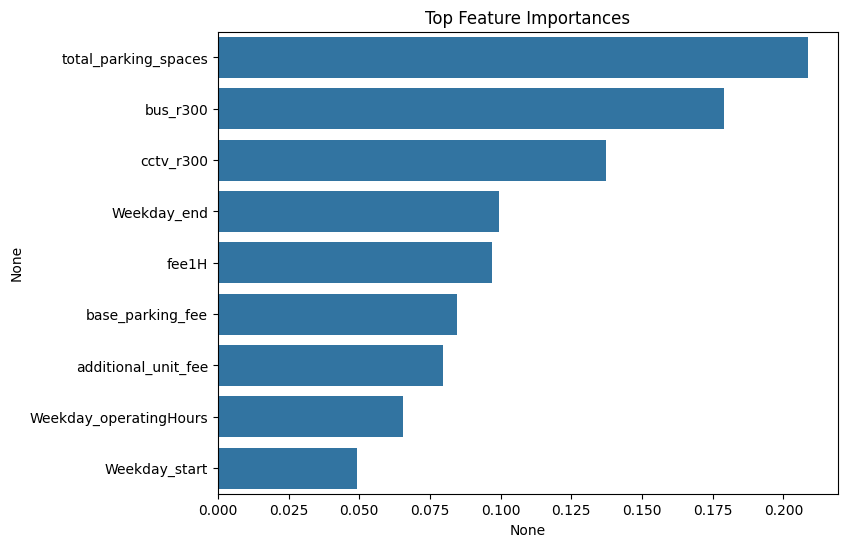

In [12]:
# 변수 중요도 플로팅
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_new.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()